<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/od_prophet_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series drift detection using KSDrift & RegressorUncertaintyDrift on weather data

## Method

## Dataset

The example uses a weather time series dataset recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/). The dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. Like the [TensorFlow time-series tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series), we only use data collected between 2009 and 2016.

In [1]:
!pip install alibi-detect

     |████████████████████████████████| 280 kB 5.1 MB/s 
     |████████████████████████████████| 4.8 MB 48.7 MB/s 
     |████████████████████████████████| 3.1 MB 43.8 MB/s 
     |████████████████████████████████| 895 kB 54.4 MB/s 
     |████████████████████████████████| 596 kB 63.7 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 3.3 MB 56.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.14.1
    Uninstalling tensorflow-probability-0.14.1:
      Successfully uninstalled tensorflow-probability-0.14.1


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import torch
from torch import nn

from alibi_detect.od import OutlierProphet
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector

# Load dataset

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
print(df.shape)
df.head()

13582336/13568290 [==============================] - 0s 0us/step
(420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Select subset to test Prophet model on:

In [9]:
n_prophet = 20000

Prophet model expects a DataFrame with 2 columns: one named ```ds``` with the timestamps and one named ```y``` with the time series to be evaluated. We will just look at the temperature data:

In [10]:
d = {'ds': df['Date Time'][:n_prophet], 'y': df['T (degC)'][:n_prophet]}
df_T = pd.DataFrame(data=d)
print(df_T.shape)
df_T.head()

(20000, 2)


,ds,y
0,2009-01-01 00:10:00,-8.02
1,2009-01-01 00:20:00,-8.41
2,2009-01-01 00:30:00,-8.51
3,2009-01-01 00:40:00,-8.31
4,2009-01-01 00:50:00,-8.27


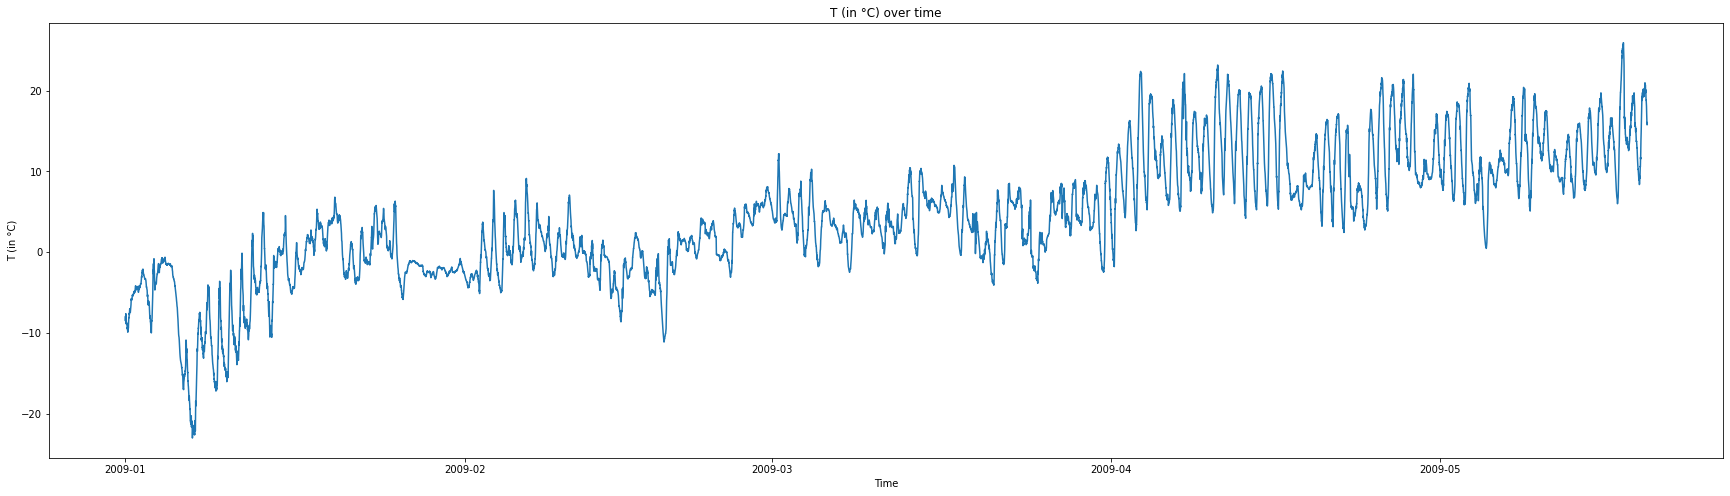

In [11]:
from matplotlib.pyplot import figure

figure(figsize=(30, 8))
plt.plot(df_T['ds'], df_T['y'])
plt.title('T (in °C) over time')
plt.xlabel('Time')
plt.ylabel('T (in °C)')
plt.show()

In [12]:
df = pd.DataFrame({'y':df_T['y']})

In [14]:

def create_timeseries_dataset(x, y, window=30, forecast=15):
    """
    *** 매우 중요한 funcation ***
    window size로 시계열 dataset의 input feature 값(train_x)과 forecast 기간의 실측 y값(train_y)
    시계열의 마지막 window 크기의 input feature 값(predict_x) 의 추출
    :param x: 실측 데이터 (pandas.DataFrame 형태)
    :param y: forecast 기간의 실측 y값(train_y, pandas.DataFrame 형태)
    :param window: 시계열 dataset의 input feature 값 size
    :param forecast: forecast 기간
                    예:'15'의 경우, window를 input으로 15개의 output을 regression 한다는 의미
    :return: train_x, train_y, predict_x
    """
    size = len(x.columns)
    train_x = []
    train_y = []

    x = x.to_numpy()
    y = y.to_numpy()
    print("input x:", x.shape)
    print("input y:", y.shape)
    for i in range(x.shape[0] - window - forecast + 1):
        sub_x = []
        for j in range(window):
            sub_x.append(x[i + j])
        train_x.append(sub_x)

        sub_y = []
        for z in range(forecast):
            sub_y.append(y[i + window + z])
        train_y.append(sub_y)

    # train_x ,train_y의 준비
    train_x = np.asarray(train_x)
    train_x = train_x.reshape(-1, window)
    train_y = np.asarray(train_y)
    '''
    if train_y.shape[2] ==1:
      train_y = train_y.reshape(-1,train_y.shape[1])
    elif train_y.shape[1] ==1:
      train_y = train_y.reshape(-1,train_y.shape[2])
    else:
      raise Exception('Not support shape!')
    '''
    predict_x = x[x.shape[0] - window:x.shape[0]]
    predict_x = predict_x.reshape(-1, window, size)

    print("outout train_x:", train_x.shape)
    print("outout train_y:", train_y.shape)
    print("outout predict_x:", predict_x.shape)

    return train_x, train_y, predict_x


In [15]:
train_x, train_y, predict_x = create_timeseries_dataset(df,df['y'],10,1)

input x: (20000, 1)
input y: (20000,)
outout train_x: (19990, 10)
outout train_y: (19990, 1)
outout predict_x: (1, 10, 1)


# Time-series predictor 구성 및 학습

In [16]:

from alibi_detect.cd import ClassifierUncertaintyDrift, RegressorUncertaintyDrift
from alibi_detect.models.tensorflow.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
from alibi_detect.models.pytorch.trainer import trainer
from alibi_detect.cd.utils import encompass_batching

In [17]:
start_pos = 0
train_size = 5000

X_train_ds = torch.utils.data.TensorDataset(torch.tensor(train_x[start_pos:start_pos+train_size]).float(), torch.tensor(train_y[start_pos:start_pos+train_size,0]).float())
X_train_dl = torch.utils.data.DataLoader(X_train_ds, batch_size=32, shuffle=False, drop_last=False)

In [18]:
reg = nn.Sequential(
    nn.Linear(10, 60),
    nn.ReLU(),
    #nn.Dropout(0.01),
    nn.Linear(60, 20),
    nn.ReLU(),
    nn.Dropout(0.01),
    nn.Linear(20, 1)
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reg.to(device)
trainer(reg, nn.MSELoss(), X_train_dl, device, torch.optim.Adam, learning_rate=0.001, epochs=30)

  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Epoch 1/30:  99%|█████████▉| 156/157 [00:01<00:00, 125.68it/s, loss_ma=15]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Epoch 30/30: 100%|██████████| 157/157 [00:01<00:00, 122.63it/s, loss_ma=2.22]


In [19]:
y_pred = []
for x in train_x[start_pos:]:
    x = torch.tensor(x).float().to(device)
    y = reg(x)
    y_pred.append(y.item())

In [21]:
A = np.array(df_T['y'][start_pos:])
B = np.array([0,0,0,0,0,0,0,0,0,0]+y_pred)
mse = pd.DataFrame((A-B)**2)

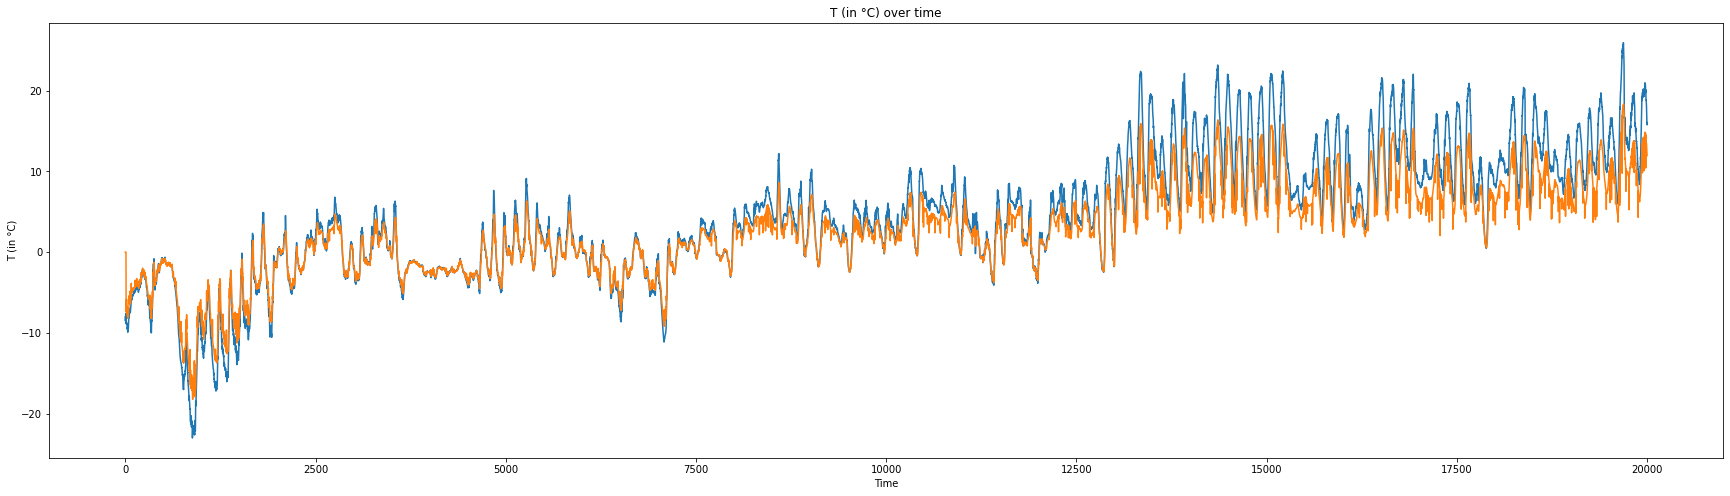

In [23]:
from matplotlib.pyplot import figure

figure(figsize=(30, 8))

plt.plot( list(df_T['y'][start_pos:]))
plt.plot( [0,0,0,0,0,0,0,0,0,0]+y_pred)
#plt.plot(mse)
plt.title('T (in °C) over time')
plt.xlabel('Time')
plt.ylabel('T (in °C)')
plt.show()

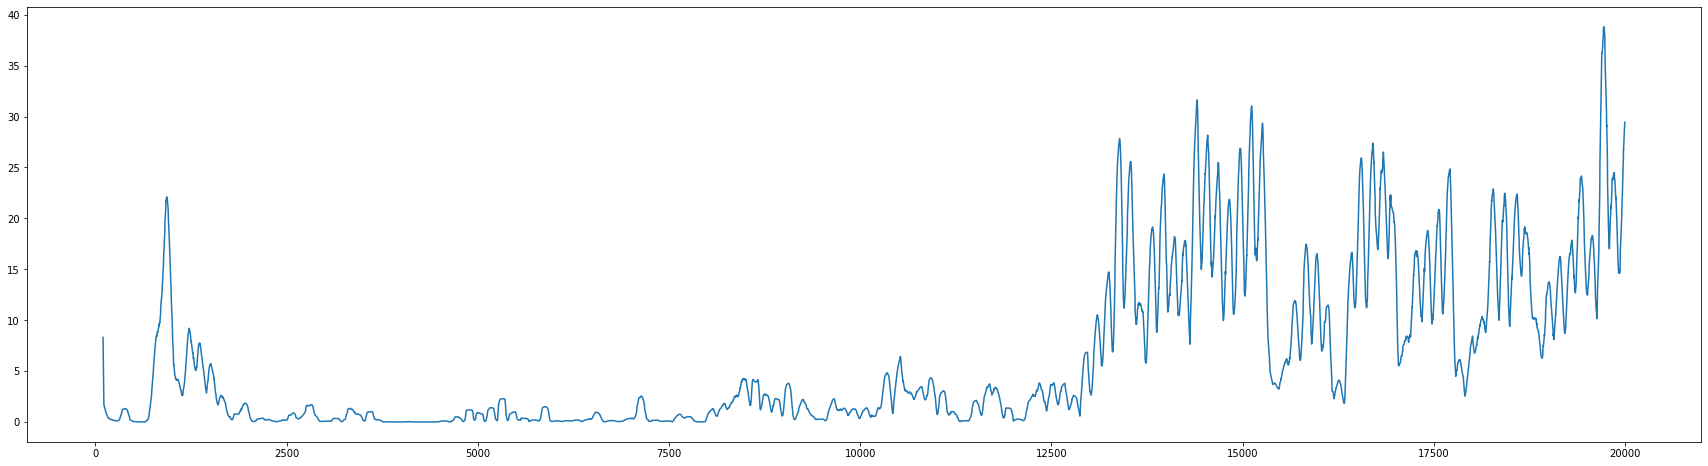

In [26]:
figure(figsize=(30, 8))
plt.plot(mse.rolling(window=100).mean())

# KSDrift 에 의한 Time-series 실험

In [45]:
from alibi_detect.cd import ChiSquareDrift, KSDrift, ClassifierDrift
bucket_size = 1000
cd = KSDrift(train_x[start_pos:start_pos+train_size], p_val=0.05)
drift_values = []
for i in range(start_pos+train_size,train_x.shape[0]):
    x_text = train_x[i-bucket_size:i]
    preds = cd.predict(x_text, drift_type='batch', return_p_val=True, return_distance=True)
    #fpreds = cd.predict(x_text, drift_type='feature')
    #is_drift_count = 0
    d = np.mean(preds['data']['distance'])
    p = np.mean(preds['data']['p_val'])
    #print(i,d,p)
    drift_values.append(d)
    '''
    for f in range(cd.n_features):
        stat = 'K-S'
        is_drift = fpreds['data']['is_drift'][f]
        stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
        if is_drift:
            pass
        else:
            print(f'{i} {f}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}')   
    '''
    print(f'\r {i}/{train_x.shape[0]} distance {d:.4f} p_val {p:.4f}', end="", flush=True)

 19989/19990 distance 0.9944 p_val 0.0000

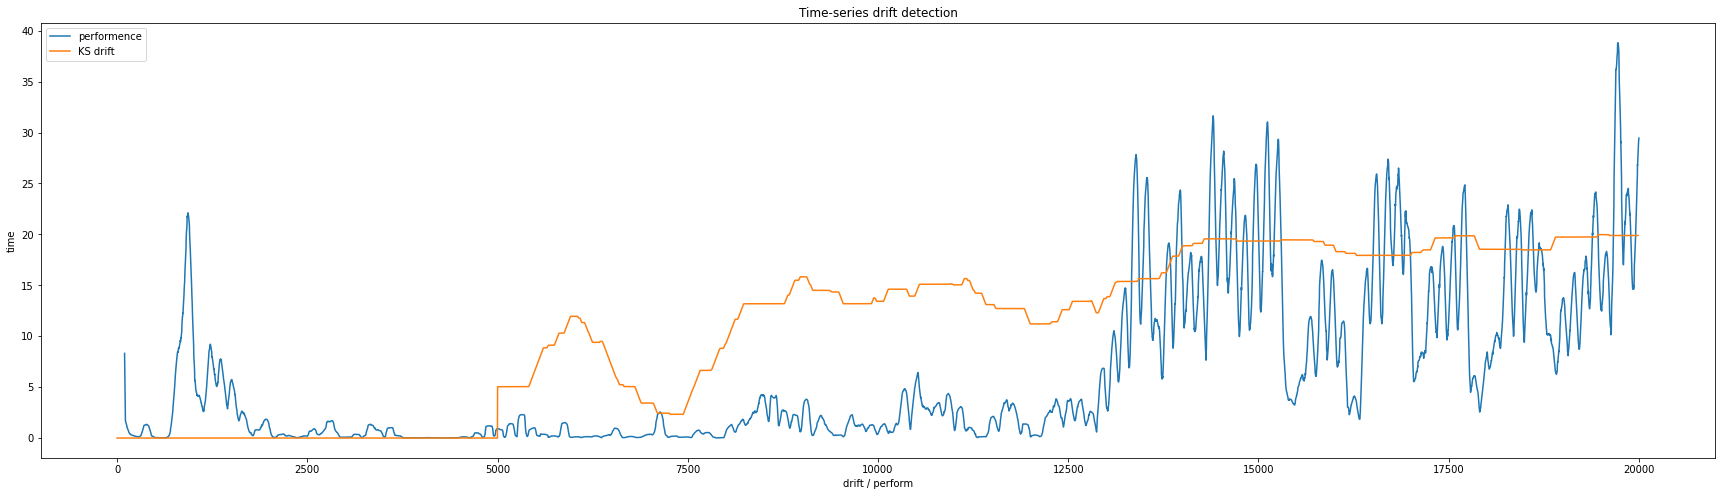

In [48]:
figure(figsize=(30, 8))
plt.plot(mse.rolling(window=100).mean(),label='performence')
plt.plot(np.array(list(np.zeros(train_size)) + drift_values)*20,label='KS drift')
plt.xlabel('drift / perform') 
plt.ylabel('time') 
plt.title("Time-series drift detection")
plt.legend()
plt.show()

# Regressor Uncertainty에 의한 Time-series 실험

In [50]:
from alibi_detect.cd import RegressorUncertaintyDrift

cd = RegressorUncertaintyDrift(
    torch.tensor(train_x[start_pos:start_pos+train_size]).float(), model=reg, backend='pytorch', p_val=0.05, uncertainty_type='mc_dropout', n_evals=10, device = device
)

In [51]:

reg_unc_drift_values = []
tc_train_x = torch.tensor(train_x).float().to(device)
for i in range(start_pos+train_size,train_x.shape[0]):
    x_text = tc_train_x[i-bucket_size:i]
    preds_h0 = cd.predict(x_text)
    d = np.mean(preds_h0['data']['distance'])
    p = np.mean(preds_h0['data']['p_val'])
    reg_unc_drift_values.append(d)
    print(f'\r {i}/{train_x.shape[0]} distance {d:.4f} p_val {p:.4f}', end="", flush=True)


 19989/19990 distance 0.1990 p_val 0.0000

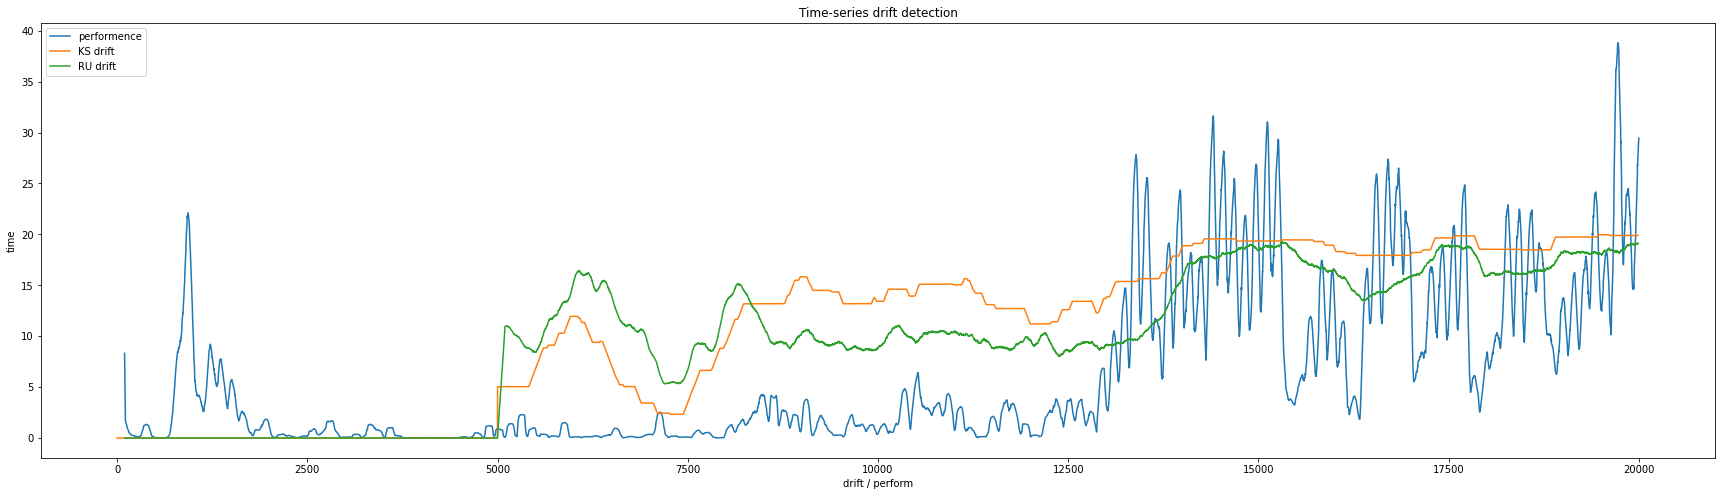

In [60]:
df_reg_unc_drift = pd.DataFrame(np.array(list(np.zeros(train_size)) + reg_unc_drift_values)*100)

figure(figsize=(30, 8))
plt.plot(mse.rolling(window=100).mean(),label='performence')
plt.plot(np.array(list(np.zeros(train_size)) + drift_values)*20,label='KS drift')
plt.plot(df_reg_unc_drift.rolling(window=100).mean(),label='RU drift')
plt.xlabel('drift / perform') 
plt.ylabel('time') 
plt.title("Time-series drift detection")
plt.legend()
plt.show()